In [1]:
import sys
sys.path.append('..')

import importlib
show_images = getattr(importlib.import_module("computer-vision.module.utility"), "show_images")

from common.utility import show_implementation

## Formal Definition of Cryptosystems
A cryptosystem consists of:
* $K$: set of all keys
* $M$: set of all plaintexts
* $C$: set of all ciphertexts
* $G$: key generation algorithm that generates a key $k \in K$
* $E$: encryption algorithm that maps a plaintext to a ciphertext, given a key $M, K \rightarrow C$
* $D$: decryption algorithm that maps a ciphertext to a plaintext, given a key $C, K \rightarrow M$

### Requirements
* Correctness: For any $m\in M, D_k(E_k(m))  = m$
* Efficiency: $G,E,D$ are performed "relatively fast", usually polynomial time
* Security: Refer to section below

#### Security
**Perfect secrecy/security** (informally) means that a attacker with any possible **prior knowledge of the plaintext**, and **unlimited computational power** cannot obtain **no additional information** of the plaintext from the ciphertext.

Practically, this means that the key must be at most as long as the message itself.

Thus, achieving perfect secrecy is impractical.

Therefore, in the case of most modern cryptosystems, we relax our requirements and aim to achieve **computational secrecy/security** instead.

**Computational secrecy/security** (informally) means that a attacker with any possible **prior knowledge of the plaintext**, and **bounded computational resources** will only obtain **additional information** of the plaintext from the ciphertext **with a tiny probability**.

* Failing with tiny probability:
    * Usually in the $2^{-60}$ range
    * Considered negligible in practice
* Bounded computational resources:
    * If we assume that the attacker has a super computer that runs $2^{80}$ instructions per year
    * And it takes 1 computational instruction to check 1 key
    * Then an attacker with a super computer since the Big Bang would have checked $2^{122}$ keys in total
    * Contrast this against the key space of at least $2^{128}$ for modern ciphers

Using the above, we can quantify the security of a system by the length of the key.

For example, a cipher with key size of $64$ bits is more secure than a cipher with $32$ bits.

However, it is to note that the "effective key size" may be different from the "actual key size".
For example, 2048-bit RSA has a known attack that takes roughly $2^{112}$ searches to crack.
Thus, the key strength is $112$ bits, despite having $2048$ bits for its key.

# Modern Ciphers
Since modern ciphers are meant to be used with any data (unlike classical ciphers that are used for text), the input, output and key of the ciphers are usually bits instead of characters.
However, the concepts are still the same.

## Stream Ciphers
Stream cipher work similarly to one time pad, but instead of giving it a bitstream, we use a key to generate a bitstream instead.
This random bitstream is termed the **keystream**.
Note that our keystream generator needs to be designed to produce cryptographically secure psuedo random sequences, to prevent attackers from being able to predict the next sequence of bits from previous bits.
 (recall one time pads)
With this setup, we only need a short key to initialize our cipher, instead of needed a bitstream that is the same length as the message.

### Examples
* RC4 (can be broken)
* A5/1 (vulnerable)

### Initial Value <span id = "iv"/>
Because most generators have a limited number of bits they can churn out before the pattern repeats (around $2^{20}$), we cannot use the same bitstream for long periods once again.

To combat this, the stream cipher takes an **Initial Value** (IV), on top of its key to generate the keystream.
Then, to encrypt the message, we choose a random IV to randomize the keystream.
Lastly, we tag on the IV as **clear text** before the ciphertext.

For decryption, the receiver simply initializes their cipher with the pre-negotiated key and the IV from the ciphertext.
Then simply use the keystream to decode the ciphertext.

We require an IV on top of a key so that we can reuse our mechanism of generating keystreams without using the introducing vulnerabilities by using same keystream for different messages.


For illustration purposes, we simply use the random package with a fixed seed to simulate a bitstream.
However, for secure implementation, one should use a cryptographically secure generator instead

In [2]:
from module.stream_cipher import StreamCipher
show_implementation(StreamCipher)

class StreamCipher:
    def __init__(self, seed):
        self.key = seed
        
    def __repr__(self):
        return f'StreamCipher(key={self.key})'
     
    def encrypt(self, message_bytes, iv=None):
        if iv is None:
            iv = randbelow(1000_000)
        
        keystream_generator = Random(self.key ^ iv)
        random_bytes = keystream_generator.randbytes(len(message_bytes))
        cipher_bytes = bytes(message_byte ^ random_byte for message_byte, random_byte in zip(message_bytes, random_bytes))
        return iv, cipher_bytes
        
    def decrypt(self, message):   
        iv, ciphertext = message
        
        return self.encrypt(ciphertext, iv)  


In [3]:
seed = 42
plaintext = b'richard of yolk gain battle in vain'
stream_cipher = StreamCipher(seed)

print(stream_cipher)
print()
print("Plaintext:".ljust(35), plaintext)
ciphertext = stream_cipher.encrypt(plaintext)

print("Ciphertext/Encrypted plaintext:".ljust(35),ciphertext)

decrypted_ciphertext = stream_cipher.decrypt(ciphertext)
print("Decrypted ciphertext:".ljust(35), decrypted_ciphertext)

StreamCipher(key=42)

Plaintext:                          b'richard of yolk gain battle in vain'
Ciphertext/Encrypted plaintext:     (173456, b'Q\n\xb9x)\xbd\xbd9A\xa5Vl\xe5\xe2\xa4\xbc\x18~1r\xe6\x13\xe0=\xd9F\xdaA\xcbFq\x18\x0e\x05\xef')
Decrypted ciphertext:               (173456, b'richard of yolk gain battle in vain')


#### Purpose of IV
Suppose that we have plaintext messages $M_1, M_2$ that are encrypted to ciphertext $C_1, C_2$ using the same key.
Because there is no IV, the bitstream $B$ used to encrypt the two plaintext is the same.

Suppose that the attacker has access to $C_1$ and $C_2$.
If they compute $C_1 \oplus C_2$, what they will get is 

$$
C_1 \oplus C_2 = (M_1 \oplus B) \oplus (M_2 \oplus B)
= (M_1 \oplus M_2)
$$

Thus, the attacker managed to get the XOR of the two messages.
From the surface, it does not seem like it leaks any useful information about the messages themselves.
However, it definitely does, and it becomes apparent when we consider the following.

In [4]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [5]:
rose_image = Image.open('../computer-vision/images/rose.jpg')
rose_image = rose_image.convert('L').resize((300, 300))
rose_image = np.array(rose_image)

words_image = Image.open('../computer-vision/images/words.jpg')
words_image = words_image.convert('L').resize((300, 300))
words_image = np.array(words_image)

seed = 42
stream_cipher = StreamCipher(seed)

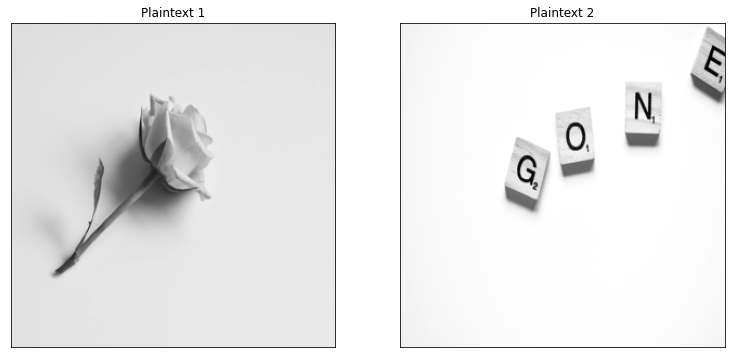

In [6]:
show_images([(rose_image, "Plaintext 1"), (words_image, "Plaintext 2")])

Photo by Jess Bailey Designs from Pexels

In this case, our plaintexts are two images.

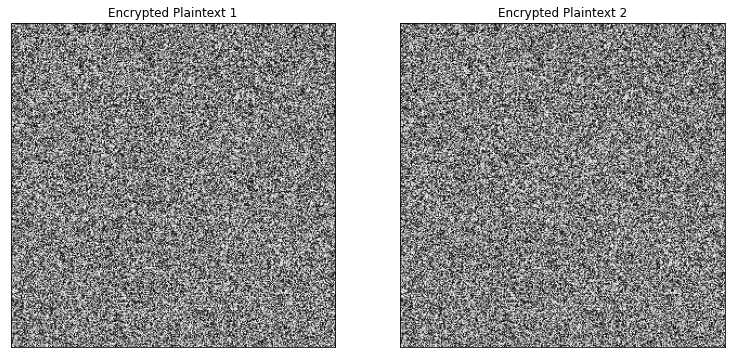

In [7]:
rose_bytes = rose_image.tobytes()
words_bytes = words_image.tobytes()

iv = 0
## Encrypt using same IV
_, rose_encrypted_bytes = stream_cipher.encrypt(rose_bytes, iv=iv)
_, words_encrypted_bytes = stream_cipher.encrypt(words_bytes, iv=iv)

rose_encrypted_image = np.ndarray((300, 300), np.uint8, rose_encrypted_bytes)
words_encrypted_image = np.ndarray((300, 300), np.uint8, words_encrypted_bytes)

show_images([(rose_encrypted_image, "Encrypted Plaintext 1"), (words_encrypted_image, "Encrypted Plaintext 2")])

As we can see, the individual ciphertext shows no (observable) information about the plaintext.

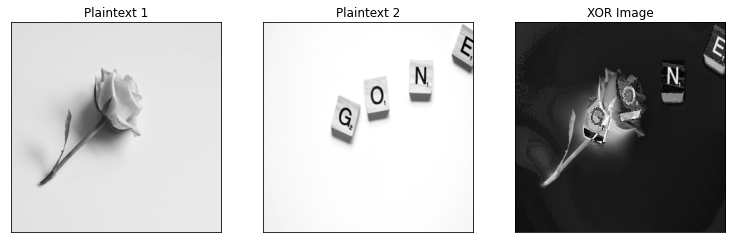

In [8]:
xor_bytes = bytes(b1 ^ b2 for b1, b2 in zip(rose_encrypted_bytes, words_encrypted_bytes))
xor_image = np.ndarray((300, 300), np.uint8, xor_bytes)

show_images([(rose_image, "Plaintext 1"), (words_image, "Plaintext 2"), (xor_image, "XOR Image")])

As we can see, despite the result being a amalgamation of the two images, we can still make out parts of each image, thus leaking information about the plaintext.

Hence, we use an IV to prevents (more accurately, reduce the likelihood) that the same keystream is used.

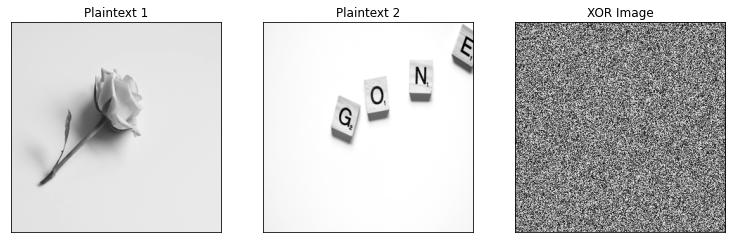

In [9]:
rose_bytes = rose_image.tobytes()
words_bytes = words_image.tobytes()

## Encrypt using random IV
_, rose_encrypted_bytes = stream_cipher.encrypt(rose_bytes)
_, words_encrypted_bytes = stream_cipher.encrypt(words_bytes)

rose_encrypted_image = np.ndarray((300, 300), np.uint8, rose_encrypted_bytes)
words_encrypted_image = np.ndarray((300, 300), np.uint8, words_encrypted_bytes)
xor_bytes = bytes(b1 ^ b2 for b1, b2 in zip(rose_encrypted_bytes, words_encrypted_bytes))
xor_image = np.ndarray((300, 300), np.uint8, xor_bytes)

show_images([(rose_image, "Plaintext 1"), (words_image, "Plaintext 2"), (xor_image, "XOR Image")])

Now, instead, the resultant XOR image does not lead information about the images.

## <div id="block-ciphers"> </div>Block Ciphers
In block ciphers, the message is split up to equal sized blocks.
**If the message does not divide nicely into blocks, padding is added to the end.**
For each block, they undergo a set number of invertible transformation, called a **round**.
The transformation of each round is affected by the **round key**, which in turn is determined by the key of the cipher.
Finally, the result is individually encrypted blocks of data.

### Examples
* DES (vulnerable due to short key length)
* AES (believed to be secure)
* A5/3

### Round
Typically, a round consist of a **substitution operation** and a **permutation operation**.
Thus, in each round, the bits are substituted with new ones then permuted, both based on the round key.
These 2 operation aims to introduce **diffusion** and **confusion** in the cipher.

#### Diffusion
Diffusion is where a change plaintext in one location will affect many parts of the ciphertext.
This means that information in the plaintext is spread over the whole ciphertext, and the transformation is equally dependent on all the bits in the plaintext.
Thus, having high diffusion ensures that attackers need access to large amount of ciphertext to determine the decryption algorithm.

By contrast, stream ciphers have low diffusion because a change of a bit in the plaintext only affects the bit in that location in the ciphertext.

#### Confusion
Confusion is where the attacker is not able to predict what will happen to the ciphertext given a change in a plaintext or key.
This means that the input undergoes a complex transformation, making it harder to determine the decryption algorithm.

### Modes of Operation
A mode of operation determines how the cipher encrypts multiple blocks of data.

#### <div id="ecb"></div> Electronic Code Book
![ECB Decryption Diagram](https://upload.wikimedia.org/wikipedia/commons/d/d6/ECB_encryption.svg)
![ECB Decryption Diagram](https://upload.wikimedia.org/wikipedia/commons/e/e6/ECB_decryption.svg)
(All diagrams obtained from Wikipedia)

ECB is the simplest mode, however, it is insecure.
Each block is encrypted/decrypted using the block cipher with the same key.

Suppose that two blocks in the plaintext are identical, then using ECB, both blocks will be the same in the ciphertext.
This leaks some information about the plaintext.
One might think that it is unlikely that two blocks are the same, or that having information of which blocks are the identical in the plaintext is not useful.

Once again, the severity of this can be illustrated by encryption of an image:

In [10]:
words_image = Image.open('../computer-vision/images/words.jpg')
words_image = words_image.convert('1')

words_bytes = words_image.tobytes()

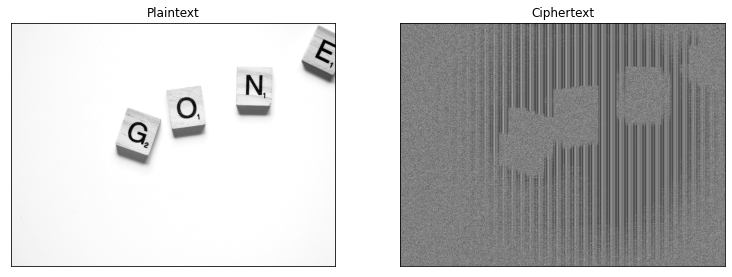

In [11]:
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad
key = b'scrabblescrabble'
cipher = AES.new(key, AES.MODE_ECB)
ciphertext = cipher.encrypt(pad(words_bytes, 16))

encrypted_words_image = Image.frombytes(mode='1', size=words_image.size, data=ciphertext)
np_encrypted_words_image = np.array(encrypted_words_image)
np_words_image = np.array(words_image)

show_images([(np_words_image, "Plaintext"), (np_encrypted_words_image, "Ciphertext")])

As we can see, we can still make out the shape/location of the tiles even after the image is encrypted.
This is because we can identify the regions where the plaintext contains the same value.

Once again, the root cause of the problem is that we reused our key.

#### Cipher Block Chaining
![CBC Encryption Diagram](https://upload.wikimedia.org/wikipedia/commons/d/d3/Cbc_encryption.png)

In CBC, an IV is decided before encryption happens.
Then, the first block in the plaintext is XOR'ed with the IV to get a new block.
This XOR'ed block is then fed through the block cipher to obtain our corresponding block in ciphertext.

Then, this encrypted block is XOR'ed with the next block in the plaintext, before being fed into the block cipher.

In general, each plaintext block is XOR'ed with the previous ciphertext block (the first plaintext is XOR'ed with the IV instead) to obtain the corresponding ciphertext block.

For decryption, the following process is used
<a id="cbc-decryption-diagram">![CBC Decryption Diagram](https://upload.wikimedia.org/wikipedia/commons/2/2a/CBC_decryption.svg)</a>

#### Counter Mode
In CTR, an IV is once again decided before encryption.
For each plaintext block, we increment the IV by 1 and pass it into the block cipher to obtain a encrypted block.
Then, we simply XOR the plaintext block with this encrypted block to obtain our ciphertext block.
Notice that this mode of operation essentially turns the block cipher into a stream cipher.

### Attacks on Block Ciphers
#### Meet in the middle attack
We know that DES is not secure due to its small $56$ bit key size.
Notice that DES does not form a group, meaning $E_{k_1} (E_{k_2}(x)) \neq E_{k_3}(x)$ for some $k_3$.
Or in simpler terms, encrypting twice with different keys is not equivalent to encrypting once with a single key.
Thus, if we encrypt twice as in 2DES, the key size is now $112$ bits.

However, consider this.
Suppose that the attacker performs a known plaintext attack. 
This mean they know the plaintext $P$ and the corresponding ciphertext $C = E_{k_1} (E_{k_2}(P))$.
Now, they can encrypt their plaintext with all possible $56$ bits keys $k_A$ to obtain $2^{56}$ different values of $A = E_{k_A}(P)$ .
We store the above in a hash table, which allows constant time lookup for presence of an item.
(Storing these keys may take an infeasibally large amount of space, but remember that we assume our attacker has unlimited resources at their disposal).

Then they can decrypt their known ciphertext using all possible keys $k_B$ also, to obtain $2^56$ different corresponding $B = D_{k_B}E_{k_1} (E_{k_2}(P))$.
For each $B$, we check if there is an $A$ in our hash table such that $A = B$.
Notice when this only happens when $A = k_2$ and $B= k_1$, which means we found the keys.

Thus, since this process took $2 \times 2^{56}$ computations, the effective key size is only $57$ bits.

Hence, for a more secure DES encryption method, the suggested way is to use 3DES, which encrypts it 3 times, which has effectively 112 bits of security.
However, it is to note that this process is 3 time slower than regular DES, and also has been depreciated by NIST over security concerns.

#### Padding Oracle Attack
It is known that AES CBC mode is susceptible to the padding oracle attack.
This assumes that the attacker has access to some Padding Oracle.

##### Padding
Recall that block ciphers need each block to be of certain size.
Thus if the plaintext does not divide nicely into blocks, we need a policy to pad the data out so that they are of the correct size.
A common padding standard is PKCS#7, which is performed as follows:
* Suppose that the last block is missing $k$ bytes to fill the block. Then fill in the last $k$ bytes with byte of value $k$.
* If the last block is full, fill an extra block of 0's instead

##### Padding Oracle
The oracle, when given a ciphertext, will output whether the decrypted ciphertext has correct padding.
In order words, it replies with whether the ciphertext is corresponds to some valid plaintext.
Notice that from the surface, it does not seem like the attacker can decrypt the message of their desired ciphertext, they can only know the validity of the ciphertext they provide to the oracle.

Suppose that the attack has the ciphertext $IV || C$ and wish to find the corresponding plaintext $P$.
They can do so without even finding out the key.

##### Decrypting the last byte
###### Finding an IV'
Remember that if $C$ has more than 1 block, the first block is not the block that is padded, thus the oracle may not always reply TRUE to $IV || C_1$.
Suppose that the attacker modify IV to IV', by changing the last byte to $z$.
Suppose that the attacker finds a $z$ such that the oracle replies TRUE to $IV' || c_1$.
Now, there might either be 1 value of $z$ which works, or 2 values of $z$ which works.

If there is only 1 value of $z$, then we know that the decrypted $c_1$ using IV' must have its last byte be 0x01, to conform to the padding format.

If there are 2 values of $z$, we know that one of them correspond to the above case, and other correspond to the decrypted $c_1$ conforming to one of the below cases.
* [??, ??, ??, ??, ??, ??, 02, 02]
* [??, ??, ??, ??, ??, 03, 03, 03]
* $\cdots$
* [??, 07, 07, 07, 07, 07, 07, 07]
* [00, 00, 00, 00, 00, 00, 00, 00]

When this occurs, for each value of $z$, the attacker will modify the 2nd last byte of IV'.
Notice that with this, the oracle will only return TRUE for the case where the last byte in the decrypted $c_1$ correspond to a 0x01.

###### Finding the byte
Now, suppose that the attacker knows that, using a certain IV', the decrypted $c_1$ follows the padding format, and they also know the length of the padding $n$. (From the previous step, the attacker knows that the padding length is 1).
We can ignore padding length of 0, since we ensure that the last byte is never 0.

Thus, they know that the decrypted $c_1$ last $n$ bytes all have value of $n$.

We define the following:
* $y_1$: the $c_1$ right after it is decrypted using the block cipher (but before being XOR'ed with the IV)
* $p_1'$: the decrypted $c_1$ using $IV'$
* $L_n(b)$: a function that returns the last $n$ bytes of a block $b$.

(Refer to [CBC decryption diagram](#cbc-decryption-diagram) as reference)

We have the following 2 relationships.
$$
L_n(p_1') = n, n, \dots, (\times n\text{ times}) \\
L_n(p_1') = L_n(IV') \oplus L_n(y_1) \Rightarrow L_n(y_1) = L_n(p_1') \oplus L_n(IV')
$$

Note that the attacker is interested in $p_1 = y_1 \oplus IV$.

Therefore, they can obtain it by using the following relationship:

$$
L_n(p_1) = L_n(y_1) \oplus L_n(IV) =  L_n(p_1') \oplus  L_n(IV') \oplus L_n(IV) = n, n, \dots, (\times n\text{ times}) \oplus  L_n(IV') \oplus L_n(IV) 
$$

Therefore, the $i^{th}$ last byte in $p_1$ is simply $n$ $\oplus$ $i^{th}$ last byte of IV' $\oplus$ $i^{th}$ last byte of $L_n(IV)$

##### Decrypting the 2nd last byte
Now, suppose that the attacker now knows the last byte of $p_1$ is $a$.
The attacker now modifies IV to IV' by XOR-ing last byte with $0x02 \oplus a$.
Since XOR-ing IV with the last byte of $y_1$ gives $a$ as the last byte of $p_1$; by using IV', the last byte of $p_1'$ will be $0x02$.

Now, in the same vein as above, we can modify the 2nd last byte of IV' until we find a value $z$ that the oracle returns TRUE.
When this happens, we know that the last 2 bytes of $p_1'$ must both be 0x02.
Hence, using the fact that the padding is now length 2, we can use the above step to derive the 2nd last byte of the plaintext.

##### Decrypting the first block
Repeating the entire process in a similar vein, the attacker can decrypt the entire first block of $C$.

##### Decrypting the other blocks
And once $p_1$ is known, the attacker can repeat the process once again, but setting IV = $c_1$ to decrypt the second block $c_2$.
Thus, they send $c_1 || c_2$ to the oracle, then use the previous steps to decrypt the block $c_2$.
Repeatedly decrypting each block allows the whole ciphertext to be decrypted.

---

Now, one might wonder if such an oracle can introduce a vulnerability, why would anyone give the attacker an access to such an oracle.

Consider a website that accepts data, but the requirement is that this data must be encrypted with a certain pre-negotiated key.
If the decryption yields an incorrectly padded output, the website may think that the data is corrupted in some way.
Thus, it may seem natural for the website developer to respond with an error to the sender when such data is received, and a normal response if correct data is received.
This acts as padding oracle unknowingly.

##### Demonstration

Suppose that we have the following oracle.

In [12]:
from Crypto.Util.Padding import unpad

class Oracle:
    def __init__(self, key):
        self.key = key
        
    def check(self, iv, msg):
        cipher = AES.new(self.key, AES.MODE_CBC, iv)
        try:
            unpad(cipher.decrypt(msg), AES.block_size)
            return True
        except ValueError:
            return False
        
# Note that only the oracle knows the key, the attacker will not know this key
oracle = Oracle(b'a_irrelavent_key')

And that we have the following ciphertext and iv, which was produced when encrypted using the same key the oracle is currently holding.

In [13]:
ciphertext = b'\xa9Y\x8c\xd3\x1c\xafr=V\xaak\xe86}\xb4l\xf6\x1f[\xae&\xed\xe2\x8fWx\x9e+|\x98\xb5\x9a\xc9\xf9%m\x14*_\x0b\x0c<$\xc11\xc4\n\x87'
iv = b'\x005u\x84\xbe\xbc\x1b\xfaTy\xce\xe1\xe7@\xdd\xe8'

In [14]:
"""Utility function to modify the byte at an index using a function"""
def change_byte(_bytes, index, func):
    return bytes(_bytes[:index] + bytes([func(_bytes[index])]) + _bytes[index + 1:])

In [15]:
def get_last_byte(iv, ciphertext):
    for i in range(256):
        iv_prime = change_byte(iv, 15, lambda _:i)
        result = oracle.check(iv_prime, ciphertext[:16])
        if result:
            if oracle.check(change_byte(iv_prime, 14, lambda b: (b + 1) % 256), ciphertext[:16]):
                return i ^ iv[15] ^ 1

def get_nth_byte(iv, cipher_block, byte_pos, pad_len):
    for i in range(256):
        iv_prime = change_byte(iv, byte_pos, lambda _: i)
        result = oracle.check(iv_prime, cipher_block)
        if result:
            return i ^ iv[byte_pos] ^ pad_len
        
def get_block(iv, cipher_block):
    prev_byte = get_last_byte(iv, cipher_block)
    known_bytes = [prev_byte]
    for byte_pos in range(14, -1, -1):
        new_iv = iv
        pad_len = len(known_bytes) + 1
        for known_byte, idx in zip(known_bytes, range(15, -1, -1)):
            new_iv = change_byte(new_iv, idx, lambda b: known_byte ^ pad_len ^ b)

        new_known_byte = get_nth_byte(new_iv, cipher_block, byte_pos, pad_len)
        known_bytes.append(new_known_byte)
    return known_bytes[::-1]

def get_message(iv, ciphertext):
    all_blocks = [get_block(iv, ciphertext[:AES.block_size])]
    for i in range(AES.block_size, len(ciphertext), AES.block_size):
        all_blocks.append(get_block(ciphertext[i - AES.block_size : i], ciphertext[i: i + AES.block_size]))
    plaintext = [item for subl in all_blocks for item in subl]
    return bytes(plaintext)

In [16]:
get_message(iv, ciphertext)

b'haha_aes_cbc_goes_brrrrrrrrrrrrrrr\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e'

## Comparison of stream cipher and block cipher

|   |Stream Cipher| Block Cipher |
|:--|---|---|
|Diffusion|Low|High|
|Error Propagation| Low | High |
|Immune to symbol insertion/deletion| No | Yes |
|Speed| Faster | Slower |
|Requires Padding| No | Yes |

Note that amount of diffusion, error propagation and immunity to symbol insertion/deletion are all related.

If the cipher has high diffusion, then it means that modification in one location affects many location in the ciphertext.
This means that if there is an error in a small part of the message, the whole message will be corrupted, leading to large error propagation.

In a similar vein, high diffusion prevents attackers from selectively modifying parts of the message through symbol insertion/deletion because such modification will greatly affect the rest of the message.

## Confidentiality vs Integrity
Note that the goal of encryption is to achieve confidentiality.
Integrity of the message is not guaranteed with encryption.

Consider the case where Alice sends Bob the following instruction, "From Alice: Send me this amount of money, $1000".
Alice then encrypts the message using a stream cipher and sends it to Bob.
Now, even though an attacker is unable to read the message sent by Alice, they can modify the message by either appending to it or truncating it.
Thus, the attacker can now modify the amount in the transaction, despite being unable to view the message.

In [41]:
sender_cipher = StreamCipher(36)
receiver_cipher = StreamCipher(36)
iv, msg = sender_cipher.encrypt(b"From Alice: Send me this amount of money, $1000")

modified_msg = (iv, msg[:-3])
_, received_msg = receiver_cipher.decrypt(modified_msg)
print("Received message:", received_msg)

Received message: b'From Alice: Send me this amount of money, $1'


Similar attacks can be mounted on block ciphers, such as block reordering attacks.

Hence, to ensure integrity, we require [data origin authentication](./data_origin_authentication.ipynb)